<a href="https://colab.research.google.com/github/pbeles/pbeles-NLP_project_j/blob/main/Bert01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
1708/1708 [==============================] - 397s 213ms/step - loss: 0.0984 - accuracy: 0.9644
Epoch 2/2
1708/1708 [==============================] - 133s 77ms/step - loss: 0.0170 - accuracy: 0.9952


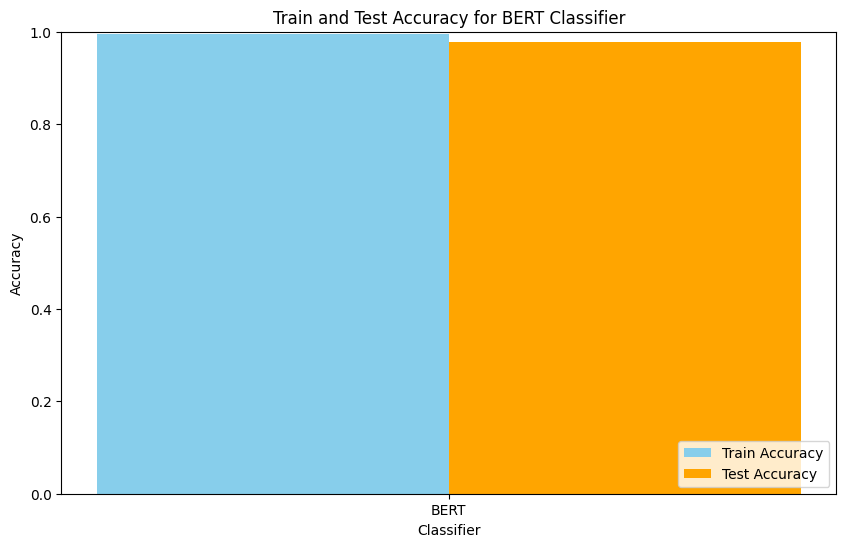

Test Accuracy for BERT Classifier: 97.76%
427/427 [==============================] - 33s 70ms/step
First 50 Predictions for BERT Classifier:
[1 1 1 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1
 1 1 1 1 1 0 1 0 0 0 0 1 0]


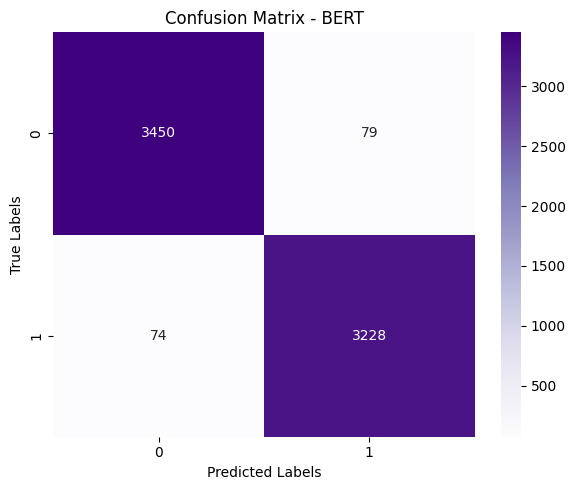

In [3]:
import pandas as pd
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, roc_auc_score, precision_recall_curve
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
import numpy as np
import os
from google.colab import files
import warnings

# Suppress warnings from Hugging Face
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")

# Load dataset
file_path = '/content/training_data_lowercase.csv'

if not os.path.exists(file_path):
    print("File not found. Please upload the dataset.")
    uploaded = files.upload()
    file_path = list(uploaded.keys())[0]

data = pd.read_csv(file_path, delimiter='\t', header=None, names=['label', 'text'])

# Train-test split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Data Preprocessing
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove single characters
    text = re.sub(r'\b[a-zA-Z]\b', '', text)
    # Substitute multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)
    # Convert to lowercase
    text = text.lower()
    return text

# Define stopwords using NLTK
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Remove stopwords function
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

# Lemmatize text (placeholder function)
def lemmatize_text(text):
    return ' '.join([word for word in text.split()])  # This will keep the words unchanged

# Apply preprocessing, stopword removal, and lemmatization
train_data['processed_text'] = train_data['text'].apply(preprocess_text)
test_data['processed_text'] = test_data['text'].apply(preprocess_text)

train_data['processed_text'] = train_data['processed_text'].apply(remove_stopwords)
test_data['processed_text'] = test_data['processed_text'].apply(remove_stopwords)

train_data['processed_text'] = train_data['processed_text'].apply(lemmatize_text)
test_data['processed_text'] = test_data['processed_text'].apply(lemmatize_text)

# BERT Classifier
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenizing the text for BERT
train_encodings = bert_tokenizer(list(train_data['text']), truncation=True, padding=True, max_length=128)
test_encodings = bert_tokenizer(list(test_data['text']), truncation=True, padding=True, max_length=128)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_data['label'])).batch(16)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_data['label'])).batch(16)

# Compile and train BERT model
bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
bert_model.fit(train_dataset, epochs=2, batch_size=16)

# Evaluate BERT model
bert_eval = bert_model.evaluate(test_dataset)
bert_train_accuracy = bert_model.evaluate(train_dataset)[1]
bert_test_accuracy = bert_eval[1]

# Combined Bar Plot for Train and Test Accuracy
plt.figure(figsize=(10, 6))
indices = np.arange(1)
width = 0.3

train_accuracies = [bert_train_accuracy]
test_accuracies = [bert_test_accuracy]
classifiers = ['BERT']

plt.bar(indices - width/2, train_accuracies, width, color='skyblue', label='Train Accuracy')
plt.bar(indices + width/2, test_accuracies, width, color='orange', label='Test Accuracy')

plt.ylim(0, 1)
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy for BERT Classifier')
plt.xticks(indices, classifiers)
plt.legend(loc='lower right')
plt.show()

# Print test accuracy for BERT classifier
print("Test Accuracy for BERT Classifier: {:.2f}%".format(bert_test_accuracy * 100))

# Generate predictions for BERT
y_pred_bert_logits = bert_model.predict(test_dataset).logits
y_pred_bert = np.argmax(y_pred_bert_logits, axis=1)

# Print first 50 predictions for BERT Classifier
print("First 50 Predictions for BERT Classifier:")
print(y_pred_bert[:50])

# Confusion Matrix for BERT
conf_matrix_bert = confusion_matrix(test_data['label'], y_pred_bert)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_bert, annot=True, cmap='Purples', fmt='g')
plt.title('Confusion Matrix - BERT')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()